In [40]:
import sys
sys.path.append('../src')
sys.setrecursionlimit(10**6)

import matplotlib.pyplot as plt
from PIL import Image
import cv2

from datasets import *
from geometry_matching import *
import scipy.spatial

In [2]:
def load_image(path):
    """Load image, convert it to grayscale and resize it."""
    img = Image.open(path).convert('L')
    img.thumbnail((400, 400))
    return np.array(img.getdata()).astype(dtype='uint8').reshape((img.size[1], -1))

In [47]:
def draw_point_clouds(points1, points2, offset, ax):
    ax.scatter(points1[:, 0], points1[:,1], marker='+', s=60, color='b', label='image1')
    ax.scatter(points2[:,0] + offset, points2[:, 1], marker='+', s=60, color='r', label='image2')
    ax.legend(loc=0)

In [3]:
sift = cv2.xfeatures2d.SIFT_create()

In [23]:
def sift_match_images(img1, img2):
    sift = cv2.xfeatures2d.SIFT_create()
    kp1, des1 = sift.detectAndCompute(img1, None)
    kp2, des2 = sift.detectAndCompute(img2, None)
    
    bf = cv2.BFMatcher(cv2.NORM_L2)
    matches = bf.knnMatch(des1,des2, k=2)
    
    # Apply ratio test
    good_matches = []
    for m,n in matches:
        if m.distance < 0.75*n.distance:
            good_matches.append([m])
    
    # cv2.drawMatchesKnn expects list of lists as matches.
    img3 = cv2.drawMatchesKnn(img1, kp1, img2, kp2, good_matches, (255,0,0), flags=2)
    fig, ax = plt.subplots(1, 1, figsize=(15, 10))
    ax.imshow(img3)
    ax.axis('off')

In [5]:
img1 = load_image('../data/notre_dame_1.jpg')
img2 = load_image('../data/notre_dame_2.jpg')
img3 = load_image('../data/notre_dame_3.jpg')
img4 = load_image('../data/not_notre_dame.jpg')

# kp1, desc1 = sift.detectAndCompute(img1, None)
# kp2, desc2 = sift.detectAndCompute(img2, None)
# kp3, desc3 = sift.detectAndCompute(img3, None)
# kp4, desc4 = sift.detectAndCompute(img4, None)

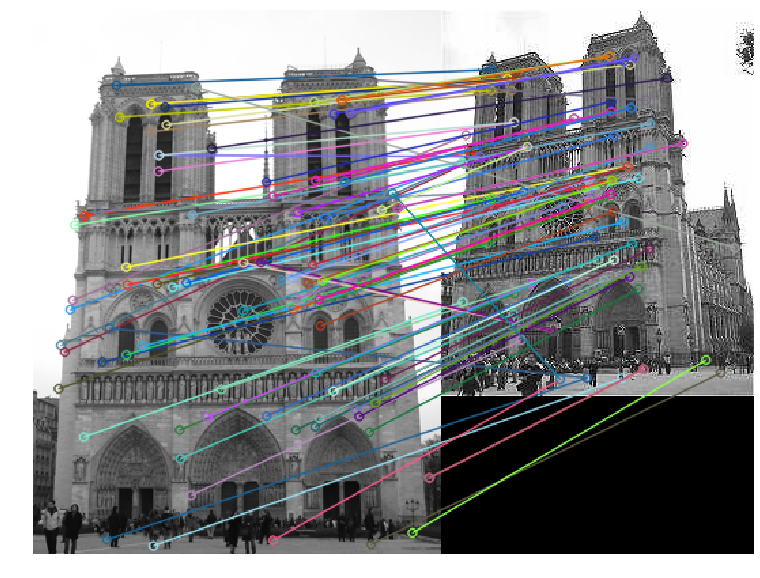

In [24]:
sift_match_images(img1, img3)

In [35]:
sift = cv2.xfeatures2d.SIFT_create()
kp1, des1 = sift.detectAndCompute(img1, None)
kp2, des2 = sift.detectAndCompute(img2, None)
sift_distances = np.array([[np.linalg.norm(d1 - d2) for d2 in des2] for d1 in des1])

N = 50
kp1_, des1_ = kp1[:N], des1[:N]
kp2_, des2_ = kp2[:N], des2[:N]
points1 = np.array([p.pt for p in kp1_])
points2 = np.array([p.pt for p in kp2_])

T = 20
nNN=300
triangles1, triangles1_indexes = pick_triangles(points1, T)
features1 = compute_features(triangles1.reshape((-1,3,2)))
triangles2 = extract_all_triangles(points2)
features2 = compute_features(triangles2.reshape((-1,3,2))).reshape((N, N, N, 3))

In [36]:
features1.shape

(1000, 3)

In [37]:
triangles1.shape

(50, 20, 3, 2)

In [112]:
def geometric_match(img1, img2):
    def triangle_similarity(triangle1, triangle2):
        vect1 = np.vstack([triangle1[1] - triangle1[0],
                           triangle1[2] - triangle1[1],
                           triangle1[0] - triangle1[2]])
        vect2 = np.vstack([triangle2[1] - triangle2[0],
                           triangle2[2] - triangle2[1],
                           triangle2[0] - triangle2[2]])
        vect1 = vect1/(np.linalg.norm(vect1, axis=1).reshape((-1, 1)) + 1e-12)
        vect2 = vect2/(np.linalg.norm(vect2, axis=1).reshape((-1, 1)) + 1e-12)
        angles1 = np.array([np.linalg.det(vect1[[0, 2]]),
                            np.linalg.det(vect1[[1, 0]]),
                            np.linalg.det(vect1[[2, 1]])])
        angles2 = np.array([np.linalg.det(vect2[[0, 2]]),
                            np.linalg.det(vect2[[1, 0]]),
                            np.linalg.det(vect2[[2, 1]])])
        return np.exp(-np.linalg.norm(angles1- angles2)*10)
    
    np.random.seed(1234)
    
    sift = cv2.xfeatures2d.SIFT_create()
    kp1, des1 = sift.detectAndCompute(img1, None)
    kp2, des2 = sift.detectAndCompute(img2, None)
    sift_distances = np.array([[np.linalg.norm(d1 - d2) for d2 in des2] for d1 in des1])
    
    N = 100
    K = 1
    
    min_distance = np.min(sift_distances, axis=1)
    
    indexes1 = np.argsort(min_distance)[:N]
#     indexes1 = np.random.permutation(np.arange(len(kp1)))[:N]
    indexes2 = np.argsort(sift_distances, axis=1)[indexes1, :K]
    
    kp1_, des1_ = [p for i, p in enumerate(kp1) if i in indexes1], [d for i, d in enumerate(des1) if i in indexes1]
    kp2_, des2_ = [p for i, p in enumerate(kp2) if i in indexes2.reshape(-1)], [d for i, d in enumerate(des2) if i in indexes2.reshape(-1)]
    points1 = np.array([p.pt for p in kp1_])
    points2 = np.array([p.pt for p in kp2_])
    
    T = 20
    N2 = len(points2)
    nNN=300
    triangles1, triangles1_indexes = pick_triangles(points1, T)
    features1 = compute_features(triangles1.reshape((-1,3,2)))
    triangles2 = extract_all_triangles(points2)
    features2 = compute_features(triangles2.reshape((-1,3,2))).reshape((N2, N2, N2, 3))
    
    for i in range(len(features2)): # at least two points are identical
        features2[i, i, :] = -10 
        features2[:, i, i] = -10
        features2[i, :, i] = -10
    
    nearest_distances, nearest_neighbors = get_closest_features(features1, features2, nNN)

    nearest_neighbors_indexes = np.concatenate([
        (nearest_neighbors.reshape((-1,1)) // (N**2) % N) ,
        (nearest_neighbors.reshape((-1,1)) // N) % N,
        nearest_neighbors.reshape((-1,1)) %  N], axis = 1).reshape((-1, T, nNN, 3))

    nearest_neighbors = nearest_neighbors.reshape((-1, T, nNN))
    
    potentials = np.exp(-(nearest_distances / np.mean(nearest_distances)))
    potentials = potentials.reshape((N, T, nNN))

    # Run power iteration algorithm one the potential to extract the mapping
    mapping = power_iteration(triangles1_indexes, nearest_neighbors_indexes, potentials, N, N)
    
    similarities = np.zeros((N, T))
    for n in range(N):
        for t in range(T):
            first_triangle = triangles1[n][t]
            second_triangle = np.array([points2[mapping[i]] for i in triangles1_indexes[n][t]])
            similarities[n][t] = triangle_similarity(first_triangle, second_triangle)

    score = np.mean(similarities, axis=1)
    print(score)
    
    threshold = 0.0001

    fig, ax = plt.subplots(1, 1, figsize=(15, 8))
    draw_point_clouds(points1, points2, 100., ax) 

    for i1, i2 in zip(np.arange(N)[score>threshold], mapping[score>threshold]):
        ax.plot([points1[i1][0], points2[i2][0]+100.], [points1[i1][1], points2[i2][1]], 
                linestyle='--', color='gray')

Epoch 1
||Vn - Vn_1|| = 99.25648279107448
Epoch 2
||Vn - Vn_1|| = 0.7091531943847104
Epoch 3
||Vn - Vn_1|| = 0.0031108718425645198
Epoch 4
||Vn - Vn_1|| = 9.682777959158158e-06
Stop after 3 iterations
[5.10592852e-03 1.21053005e-02 1.01079349e-03 7.88222782e-03
 4.00351307e-02 3.23358944e-02 7.76268925e-03 1.93719194e-03
 3.16907399e-02 3.56038222e-03 2.94602491e-03 6.49251724e-02
 6.35048257e-03 1.87835577e-03 1.27719323e-02 3.36513932e-02
 1.81908798e-03 5.64466204e-04 5.38120498e-04 1.88905316e-02
 7.03925947e-03 6.52515669e-03 5.21021360e-02 4.14902251e-02
 9.61723746e-03 3.33160107e-04 3.48222754e-04 8.67432932e-05
 3.55798137e-02 1.30846464e-02 1.65834768e-02 7.54440017e-03
 8.86079462e-04 1.69086566e-02 1.91439678e-02 1.08713548e-03
 2.43034593e-02 6.88029980e-04 1.13771344e-02 6.03273017e-03
 2.52868363e-02 3.09902491e-02 1.93961727e-03 4.60376526e-03
 1.99960172e-02 3.77311075e-02 5.74064681e-03 1.48380049e-03
 2.05679547e-02 1.14371861e-02 4.36667666e-02 2.27337581e-03
 1.619

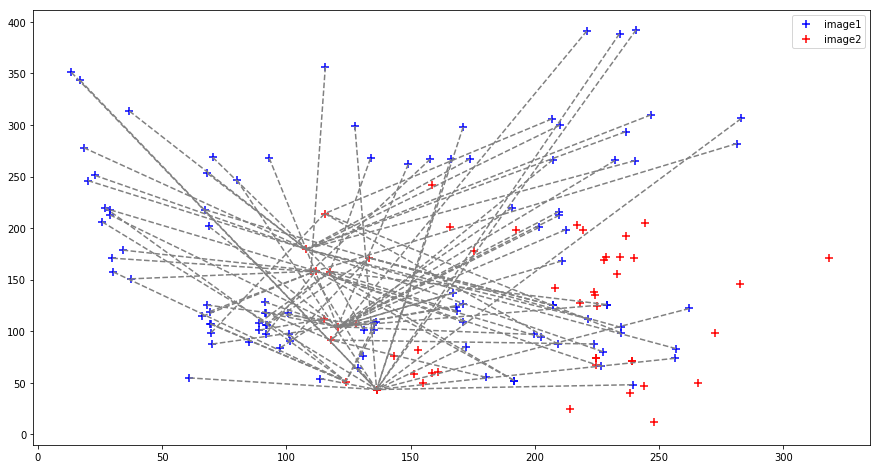

In [113]:
geometric_match(img1, img3)